<a href="https://colab.research.google.com/github/DCajiao/Time-series-forecast-of-energy-consumption-in-Tetouan-City/blob/main/notebooks/02_assembly_model_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Entrenamiento, Predicción y Evaluación de los modelos de ensamble

#### Importación de Datos

In [ ]:
import requests
import pandas as pd
import numpy as np
import sys, os, math, typing as t
import warnings
import time

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from io import BytesIO
from dataclasses import dataclass
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from datetime import timedelta

plt.rcParams.update({
    "figure.figsize": (12, 5),
    "axes.grid": True
})

warnings.filterwarnings('ignore')

In [ ]:
# Importar datos
DATA_GITHUB_URL = 'https://raw.githubusercontent.com/DCajiao/Time-series-forecast-of-energy-consumption-in-Tetouan-City/refs/heads/main/data/zone1_power_consumption_of_tetouan_city.csv'

# Descargar los datos desde github
response = requests.get(DATA_GITHUB_URL)

# Convertir en un df desde el xlsx de github
df = pd.read_csv(BytesIO(response.content), sep=',')

df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")
df = df.set_index("datetime")

# Validaciones mínimas
expected_cols = {"temperature","humidity","general_diffuse_flows","zone_1"}
missing = expected_cols - set(df.columns)
if missing:
    raise ValueError(f"Faltan columnas en el dataset: {missing}. "
                     f"Columnas disponibles: {df.columns.tolist()}")

print("\nFrecuencia aproximada:", (df.index.to_series().diff().mode().iloc[0]))
print("Filas totales:", len(df))


Frecuencia aproximada: 0 days 00:10:00
Filas totales: 52416


#### Definición de Funciones y Partición de los datos

In [ ]:
from typing import Optional, Dict

def temporal_split(df: pd.DataFrame, train_size=0.7, val_size=0.2):
    """Split temporal 70/20/10 por defecto."""
    n = len(df)
    n_train = int(n * train_size)
    n_val = int(n * val_size)
    train = df.iloc[:n_train]
    val = df.iloc[n_train:n_train+n_val]
    test = df.iloc[n_train+n_val:]
    return train, val, test

def make_windows(
    data: pd.DataFrame,
    target_col: str,
    feature_cols: t.List[str],
    history: int = 1008,   # 7 días de 10-min
    target_shift: int = 1   # 1 paso adelante
):
    """Crea X, y con ventana deslizante. X tiene forma (N, history, F).
    Para modelos tipo sklearn, se devuelve además X2 (aplanado)."""
    feats = data[feature_cols].values
    target = data[target_col].values
    X, y = [], []
    for i in range(len(data) - history - target_shift + 1):
        X.append(feats[i:i+history])
        y.append(target[i+history+target_shift-1])
    X = np.array(X)
    y = np.array(y)
    # Aplanado para modelos de tabular (árboles, etc.)
    ns, h, f = X.shape
    X2 = X.reshape((ns, h*f))
    return X, X2, y

def smape(y_true, y_pred, eps: float = 1e-8):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred)) + eps
    return np.mean(2.0 * np.abs(y_pred - y_true) / denom) * 100.0

def wape(y_true, y_pred, eps: float = 1e-8):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    return (np.sum(np.abs(y_pred - y_true)) / (np.sum(np.abs(y_true)) + eps)) * 100.0

@dataclass
class Scalers:
    X: Optional[StandardScaler] = None
    y: Optional[StandardScaler] = None

def fit_scalers(train_df: pd.DataFrame, feature_cols: t.List[str], target_col: str) -> Scalers:
    sx = StandardScaler()
    sy = StandardScaler()
    sx.fit(train_df[feature_cols])
    sy.fit(train_df[[target_col]])
    return Scalers(X=sx, y=sy)

def apply_scalers(df: pd.DataFrame, scalers: Scalers, feature_cols: t.List[str], target_col: str):
    out = df.copy()
    out[feature_cols] = scalers.X.transform(out[feature_cols])
    out[target_col]  = scalers.y.transform(out[[target_col]])
    return out

def inverse_target(y: np.ndarray, scalers: Scalers) -> np.ndarray:
    return scalers.y.inverse_transform(y.reshape(-1,1)).ravel()

def plot_segment(idx, y_true, y_pred, title="Predicción (tramo)", target_name="target"):
    plt.figure(figsize=(12,4))
    plt.plot(idx, y_true, label="Real", linewidth=2)
    plt.plot(idx, y_pred, label="Pred", linewidth=2)
    plt.title(title)
    plt.xlabel("Tiempo"); plt.ylabel(target_name); plt.legend(); plt.tight_layout(); plt.show()


In [ ]:
TARGET_COL = "zone_1"  # consumo a pronosticar
EXOG_COLS = ["temperature", "humidity", "general_diffuse_flows"]  # exógenas priorizadas

# Ordenar columnas por claridad (target al final)
cols = EXOG_COLS + [TARGET_COL]
df2 = df[cols].copy().astype("float32")

# Splits temporales base (para val/test)
train_df_full, val_df, test_df = temporal_split(df2, train_size=0.7, val_size=0.2)
print({s: len(x) for s,x in [('train_full',train_df_full),('val',val_df),('test',test_df)]})

# Entrenar con los últimos 45 días
POINTS_PER_DAY = 24 * 6           # 10 min = 6 puntos por hora = 144 por día
TRAIN_DAYS = 45
WINDOW_TRAIN_POINTS = TRAIN_DAYS * POINTS_PER_DAY  # 45 * 144 = 6480

HISTORY_WINDOW = 7 * POINTS_PER_DAY   # 7 días = 1008 pasos
SHIFT_ONE_STEP = 1                    # +10 min

# Tomamos exactamente los últimos 45 días como training
train_df = train_df_full.tail(WINDOW_TRAIN_POINTS)

print(
    "train_df (últimos 45 días) =",
    train_df.index.min(), "→", train_df.index.max(),
    "| filas:", len(train_df)
)

# Escalado Z-score (stats SOLO del train de 45 días)
scalers = fit_scalers(train_df, EXOG_COLS, TARGET_COL)
train_n = apply_scalers(train_df, scalers, EXOG_COLS, TARGET_COL)
val_n   = apply_scalers(val_df,   scalers, EXOG_COLS, TARGET_COL)
test_n  = apply_scalers(test_df,  scalers, EXOG_COLS, TARGET_COL)

# Ventanas one-step (history=1008, shift=1)
Xtr, Xtr2, ytr = make_windows(
    train_n, TARGET_COL, EXOG_COLS + [TARGET_COL],
    history=HISTORY_WINDOW, target_shift=SHIFT_ONE_STEP
)
Xva, Xva2, yva = make_windows(
    val_n, TARGET_COL, EXOG_COLS + [TARGET_COL],
    history=HISTORY_WINDOW, target_shift=SHIFT_ONE_STEP
)
Xte, Xte2, yte = make_windows(
    test_n, TARGET_COL, EXOG_COLS + [TARGET_COL],
    history=HISTORY_WINDOW, target_shift=SHIFT_ONE_STEP
)

print("Shapes →",
      "Xtr2:", Xtr2.shape, "ytr:", ytr.shape, "|",
      "Xva2:", Xva2.shape, "yva:", yva.shape, "|",
      "Xte2:", Xte2.shape, "yte:", yte.shape)

# Validación rápida
assert Xtr2.shape[0] >= 1, "No hay suficientes filas en los últimos 45 días para formar al menos 1 ventana."

{'train_full': 36691, 'val': 10483, 'test': 5242}
train_df (últimos 45 días) = 2017-07-29 19:10:00 → 2017-09-12 19:00:00 | filas: 6480
Shapes → Xtr2: (5472, 4032) ytr: (5472,) | Xva2: (9475, 4032) yva: (9475,) | Xte2: (4234, 4032) yte: (4234,)


#### Modelo Bagging: Random Forest

##### Entrenamiento

In [ ]:
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=14,
    max_features="sqrt",
    min_samples_leaf=8,
    bootstrap=True,
    n_jobs=-1, random_state=42
)

start = time.time()
rf_model.fit(Xtr2, ytr)
end = time.time()

rf_execution_time = end - start
print(f"Random Forest entrenado en {rf_execution_time:.2f} segundos.")

Random Forest entrenado en 42.20 segundos.


##### Evaluación

In [ ]:
# Validación y prueba en escala normalizada (luego invertimos)
y_pred_val = rf_model.predict(Xva2)
y_pred_te  = rf_model.predict(Xte2)

# Invertir a escala real
y_pred_val_inv = inverse_target(y_pred_val, scalers)
y_val_inv      = inverse_target(yva, scalers)
y_pred_te_inv  = inverse_target(y_pred_te, scalers)
y_te_inv       = inverse_target(yte, scalers)

# Índice temporal alineado para el tramo del test (one-step)
start = HISTORY_WINDOW + SHIFT_ONE_STEP - 1
idx_seg = test_df.index[start : start + len(y_te_inv)]


In [ ]:
# Métricas
smape_val = smape(y_val_inv, y_pred_val_inv)
wape_val  = wape(y_val_inv, y_pred_val_inv)
smape_te  = smape(y_te_inv,  y_pred_te_inv)
wape_te   = wape(y_te_inv,   y_pred_te_inv)

print(f"[RANDOM FOREST] VAL  → sMAPE: {smape_val:.3f}% | WAPE: {wape_val:.3f}%")
print(f"[RANDOM FOREST] TEST → sMAPE: {smape_te:.3f}% | WAPE: {wape_te:.3f}%")
print(f"[RANDOM FOREST] Random Forest entrenado en {rf_execution_time:.2f} segundos.")

[RANDOM FOREST] VAL  → sMAPE: 4.622% | WAPE: 4.267%
[RANDOM FOREST] TEST → sMAPE: 7.229% | WAPE: 6.632%
[RANDOM FOREST] Random Forest entrenado en 42.20 segundos.


##### Pronóstico a 1 Paso

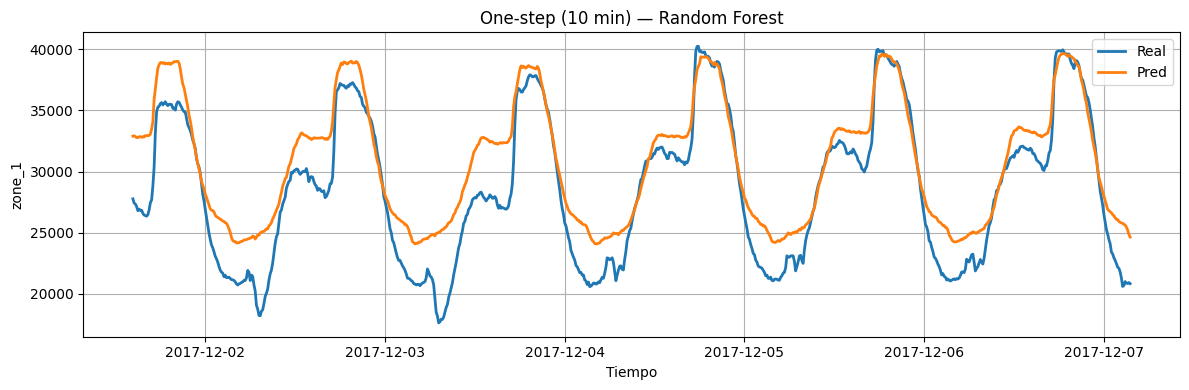

In [ ]:
# Gráfico de un tramo
plot_segment(idx_seg[:800], y_te_inv[:800], y_pred_te_inv[:800],
             title="One‑step (10 min) — Random Forest", target_name=TARGET_COL)

Se observa que el modelo logra capturar la estacionalidad diaria, pero presenta un desfase importante: sobreestima los picos de consumo y suaviza demasiado los valles, lo que explica su mayor error en one‑step (sMAPE 7.229%, WAPE 6.632%).

##### Pronóstico a Múltiples Pasos

[RANDOM FOREST] Recursive 3h → sMAPE: 2.493%
[RANDOM FOREST] Recursive 3h → WAPE: 2.597%


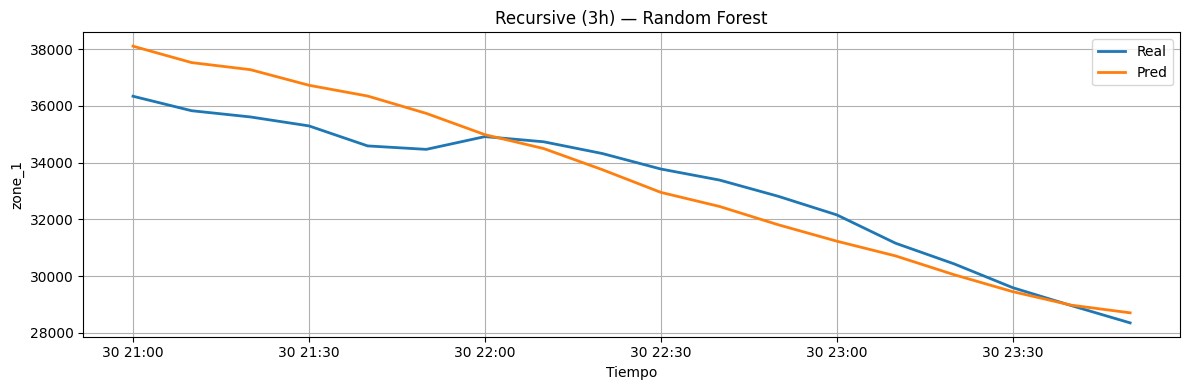

In [ ]:
# --- Pronóstico recursivo ---
def recursive_forecast(
    model,
    seed_window: np.ndarray,   # (HISTORY_WINDOW, F) en escala normalizada
    steps: int,
) -> np.ndarray:
    """
    Genera 'steps' predicciones autoregresivas.
    Se asume que la ÚLTIMA columna de seed_window es el TARGET
    (orden de features: EXOG_COLS + [TARGET_COL]).
    """
    hist = seed_window.copy()      # (H, F)
    preds = []
    for _ in range(steps):
        x = hist.reshape(1, -1)    # aplanar para modelos tabulares (sklearn)
        y_hat = model.predict(x)[0]  # escala normalizada
        preds.append(y_hat)

        # Exógenas: estrategia 'hold' (mantener último valor); actualizar TARGET con y_hat
        next_row = hist[-1].copy()
        next_row[-1] = y_hat
        hist = np.vstack([hist[1:], next_row])
    return np.array(preds)

# Construcción de la semilla desde 'test_n'
feats_order = EXOG_COLS + [TARGET_COL]

# Elegimos el seed de forma que existan 'STEPS' verdaderos luego del seed para evaluar:
STEPS = 18  # 3 horas (18 * 10 min)
# Ubicamos la semilla lo más tarde posible pero dejando espacio para 'STEPS' futuros:
seed_start = max(0, len(test_n) - (HISTORY_WINDOW + STEPS))
seed_end   = seed_start + HISTORY_WINDOW

seed_win = test_n[feats_order].values[seed_start:seed_end]  # (HISTORY_WINDOW, F)

# Predicción recursiva (normalizada) y desnormalización
y_pred_rec_norm = recursive_forecast(rf_model, seed_win, STEPS)
y_pred_rec       = inverse_target(y_pred_rec_norm, scalers)

# Verdaderos y ejes de tiempo para evaluación
true_start = seed_end
true_end   = seed_end + STEPS

y_true_rec = test_df[TARGET_COL].values[true_start:true_end]
idx_future = test_df.index[true_start:true_end]

# Seguridad: longitudes deben coincidir
assert len(y_true_rec) == len(y_pred_rec) == STEPS, "Desalineación en longitudes para evaluación recursive."

# Métricas y gráfico
smape_rec = smape(y_true_rec, y_pred_rec)
wape_rec  = wape(y_true_rec, y_pred_rec)
print(f"[RANDOM FOREST] Recursive 3h → sMAPE: {smape_rec:.3f}%")
print(f"[RANDOM FOREST] Recursive 3h → WAPE: {wape_rec:.3f}%")

plot_segment(idx_future, y_true_rec, y_pred_rec,
             title="Recursive (3h) — Random Forest", target_name=TARGET_COL)


En este escenario recursivo a 3 horas, aunque la tendencia general descendente se preserva, la predicción se mantiene sistemáticamente por debajo de los valores reales entre más se avanza en el tiempo, mostrando un sesgo de subestimación.

---

#### Modelo Boosting #1: XGBoost

##### Entrenamiento

In [ ]:
import xgboost as xgb

# Tipos livianos → menos RAM y más velocidad
Xtr2 = Xtr2.astype("float32"); ytr = ytr.astype("float32")
Xva2 = Xva2.astype("float32"); yva = yva.astype("float32")
Xte2 = Xte2.astype("float32"); yte = yte.astype("float32")

# Configuración pensada para CPU:
# - tree_method="hist": histograma (rápido en CPU)
# - max_bin reduce coste (128 suele ser buen compromiso)
# - subsample / colsample_bytree aceleran y controlan overfit
# - early_stopping para cortar a tiempo

cpu_params = dict(
    n_estimators=100,
    objective='reg:squarederror',
    random_state=42,
    tree_method='gpu_hist', # habilita GPU
    predictor='gpu_predictor',

    early_stopping_rounds=10,
    eval_metric="rmse"      # en XGB>=2.0 va en el constructor
)

booster = xgb.XGBRegressor(**cpu_params)

In [ ]:
start = time.time()
booster.fit(
    Xtr2, ytr,
    eval_set=[(Xva2, yva)],
    verbose=50
)
end = time.time()

best_iter = getattr(booster, "best_iteration", None)
xgb_execution_time = end - start

print(f"XGBoost (CPU) entrenado en {xgb_execution_time:.2f} segundos.", f"(best_iteration={best_iter})" if best_iter is not None else "")

[0]	validation_0-rmse:0.74834
[22]	validation_0-rmse:0.07816
XGBoost (CPU) entrenado en 8.84 segundos. (best_iteration=12)


##### Evaluación

In [ ]:
# ONE-STEP (XGBoost) — recalcula y usa variables exclusivas
y_pred_val_xgb = booster.predict(Xva2)
y_pred_te_xgb  = booster.predict(Xte2)

# Invertir a escala real (sin reusar arrays de RF)
y_val_inv_xgb      = inverse_target(yva, scalers)
y_pred_val_inv_xgb = inverse_target(y_pred_val_xgb, scalers)
y_te_inv_xgb       = inverse_target(yte, scalers)
y_pred_te_inv_xgb  = inverse_target(y_pred_te_xgb, scalers)

# Métricas (XGB)
smape_val_xgb = smape(y_val_inv_xgb, y_pred_val_inv_xgb)
wape_val_xgb  = wape(y_val_inv_xgb, y_pred_val_inv_xgb)
smape_te_xgb  = smape(y_te_inv_xgb,  y_pred_te_inv_xgb)
wape_te_xgb   = wape(y_te_inv_xgb,   y_pred_te_inv_xgb)

print(f"[XGB] ONE-STEP → VAL  sMAPE: {smape_val_xgb:.3f}% | WAPE: {wape_val_xgb:.3f}%")
print(f"[XGB] ONE-STEP → TEST sMAPE: {smape_te_xgb:.3f}% | WAPE: {wape_te_xgb:.3f}%")
print(f"[XGB] XGBoost (CPU) entrenado en {xgb_execution_time:.2f} segundos.")


[XGB] ONE-STEP → VAL  sMAPE: 1.247% | WAPE: 1.191%
[XGB] ONE-STEP → TEST sMAPE: 1.546% | WAPE: 1.522%
[XGB] XGBoost (CPU) entrenado en 8.84 segundos.


##### Pronóstico a 1 paso

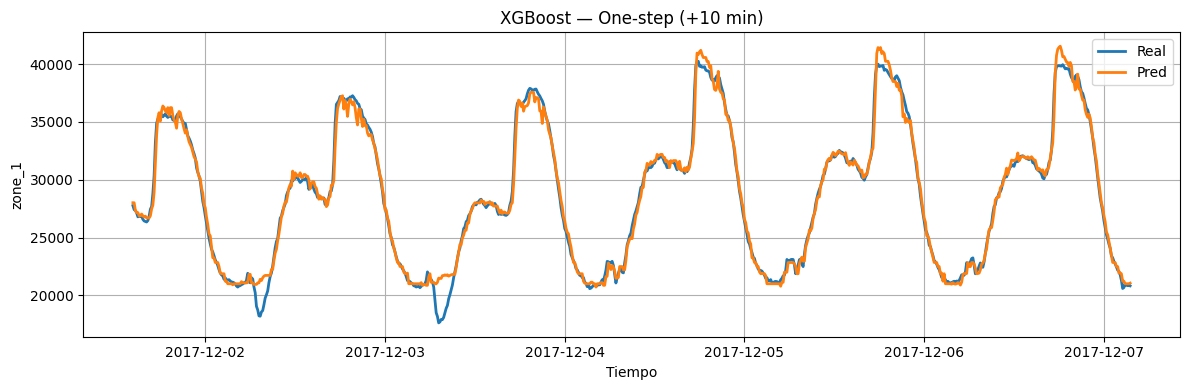

In [ ]:
# PRONÓSTICO A 1 PASO — One-step

# Predicciones en normalizado
y_pred_val = booster.predict(Xva2)
y_pred_te  = booster.predict(Xte2)

# Invertir a escala real
y_val_inv      = inverse_target(yva, scalers)
y_pred_val_inv = inverse_target(y_pred_val, scalers)
y_te_inv       = inverse_target(yte, scalers)
y_pred_te_inv  = inverse_target(y_pred_te, scalers)

# Índice temporal para graficar tramo en TEST
start = HISTORY_WINDOW + SHIFT_ONE_STEP - 1
idx_seg = test_df.index[start : start + len(y_te_inv)]

# Gráfico de tramo (opcional)
plot_segment(idx_seg[:800], y_te_inv[:800], y_pred_te_inv[:800],
             title="XGBoost — One-step (+10 min)", target_name=TARGET_COL)

XGBoost ofrece un ajuste mucho más preciso. En la gráfica de one‑step las curvas de valores reales y predichos prácticamente se superponen, siguiendo fielmente tanto los picos como la mayoría de los valles de la serie, con errores muy bajos (sMAPE 1.546%, WAPE 1.522%).

##### Pronóstico a Múltiples Pasos

[XGB] RECURSIVE (3h) → TEST sMAPE: 4.105%
[XGB] RECURSIVE (3h) → TEST WAPE: 4.036%


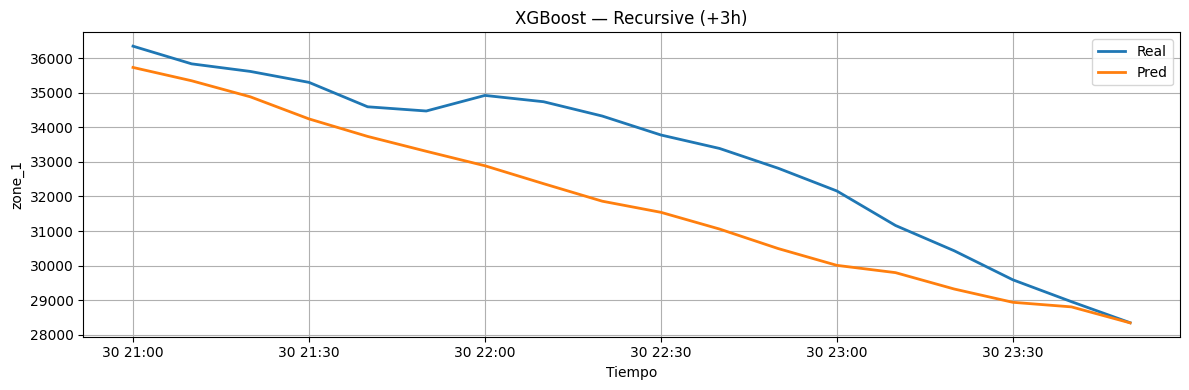

In [ ]:
# Semilla en test dejando espacio para 'STEPS' futuros (EXOG_COLS + [TARGET_COL])
STEPS = 18
feats_order = EXOG_COLS + [TARGET_COL]
seed_start_xgb = max(0, len(test_n) - (HISTORY_WINDOW + STEPS))
seed_end_xgb   = seed_start_xgb + HISTORY_WINDOW
seed_win_xgb   = test_n[feats_order].values[seed_start_xgb:seed_end_xgb]

# Predicción recursiva (normalizada) + desnormalización
y_pred_rec_norm_xgb = recursive_forecast(booster, seed_win_xgb, STEPS)
y_pred_rec_xgb      = inverse_target(y_pred_rec_norm_xgb, scalers)

# Verdaderos y tiempos (alineación propia de XGB)
true_start_xgb = seed_end_xgb
true_end_xgb   = seed_end_xgb + STEPS
y_true_rec_xgb = test_df[TARGET_COL].values[true_start_xgb:true_end_xgb]
idx_future_xgb = test_df.index[true_start_xgb:true_end_xgb]

# Métricas y gráfico (XGB)
smape_rec_xgb = smape(y_true_rec_xgb, y_pred_rec_xgb)
wape_rec_xgb  = wape(y_true_rec_xgb, y_pred_rec_xgb)
print(f"[XGB] RECURSIVE (3h) → TEST sMAPE: {smape_rec_xgb:.3f}%")
print(f"[XGB] RECURSIVE (3h) → TEST WAPE: {wape_rec_xgb:.3f}%")

plot_segment(idx_future_xgb, y_true_rec_xgb, y_pred_rec_xgb,
             title="XGBoost — Recursive (+3h)", target_name=TARGET_COL)

El modelo sigue correctamente la tendencia descendente del consumo energético, pero introduce un sesgo sistemático a la baja: las curvas real y predicha son paralelas la mayor parte del tramo, con la serie modelada siempre por debajo de la observada. Esto concuerda con el incremento del error en este escenario (sMAPE 4.105% y WAPE 4.036%), reflejando la acumulación de error que es típica en este tipo de enfoques autoregresivos.

#### Modelo Boosting #2: LightGBM

##### Entrenamiento

In [ ]:
from lightgbm import LGBMRegressor, early_stopping, log_evaluation

# Tipos livianos
Xtr2 = Xtr2.astype("float32"); ytr = ytr.astype("float32")
Xva2 = Xva2.astype("float32"); yva = yva.astype("float32")
Xte2 = Xte2.astype("float32"); yte = yte.astype("float32")

lgb_model = LGBMRegressor(
  n_estimators=100,
  device='gpu', # habilita GPU
  gpu_platform_id=0, # opcional, depende del sistema
  gpu_device_id=0
  )

# Early stopping y logging con callbacks
callbacks = [
    early_stopping(stopping_rounds=150, first_metric_only=True),
    log_evaluation(period=50)
]

In [ ]:
start = time.time()
lgb_model.fit(
    Xtr2, ytr,
    eval_set=[(Xva2, yva)],
    callbacks=callbacks
)
end = time.time()

lgb_execution_time = end - start
best_iter = getattr(lgb_model, "best_iteration_", None)
print(f"LightGBM (CPU) entrenado en {lgb_execution_time:.2f} segundos.", f"(best_iteration={best_iter})" if best_iter is not None else "")

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1025183
[LightGBM] [Info] Number of data points in the train set: 5472, number of used features: 4032
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 4032 dense feature groups (21.04 MB) transferred to GPU in 0.054213 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -0.047600
Training until validation scores don't improve for 150 rounds
[50]	valid_0's l2: 0.00456946
[100]	valid_0's l2: 0.00520792
Did not meet early stopping. Best iteration is:
[50]	valid_0's l2: 0.00456946
Evaluated only: l2
LightGBM (CPU) entrenado en 72.72 segundos. (best_iteration=50)


##### Evaluación

In [ ]:
# One-step
smape_val = smape(y_val_inv, y_pred_val_inv)
wape_val  = wape(y_val_inv, y_pred_val_inv)
smape_te  = smape(y_te_inv,  y_pred_te_inv)
wape_te   = wape(y_te_inv,   y_pred_te_inv)

print(f"[LIGHTGBM] ONE-STEP → VAL  sMAPE: {smape_val:.3f}% | WAPE: {wape_val:.3f}%")
print(f"[LIGHTGBM] ONE-STEP → TEST sMAPE: {smape_te:.3f}% | WAPE: {wape_te:.3f}%")
print(f"[LIGHTGBM] Entrenado en {lgb_execution_time:.2f} segundos.")

# Recursive (3h)
smape_rec = smape(y_true_rec, y_pred_rec)
wape_rec  = wape(y_true_rec, y_pred_rec)
print(f"[LIGHTGBM] RECURSIVE → TEST 3h sMAPE: {smape_rec:.3f}% | WAPE: {wape_rec:.3f}%")

[LIGHTGBM] ONE-STEP → VAL  sMAPE: 2.088% | WAPE: 1.851%
[LIGHTGBM] ONE-STEP → TEST sMAPE: 3.590% | WAPE: 3.113%
[LIGHTGBM] Entrenado en 72.72 segundos.
[LIGHTGBM] RECURSIVE → TEST 3h sMAPE: 4.556% | WAPE: 4.472%


##### Pronóstico a 1 paso

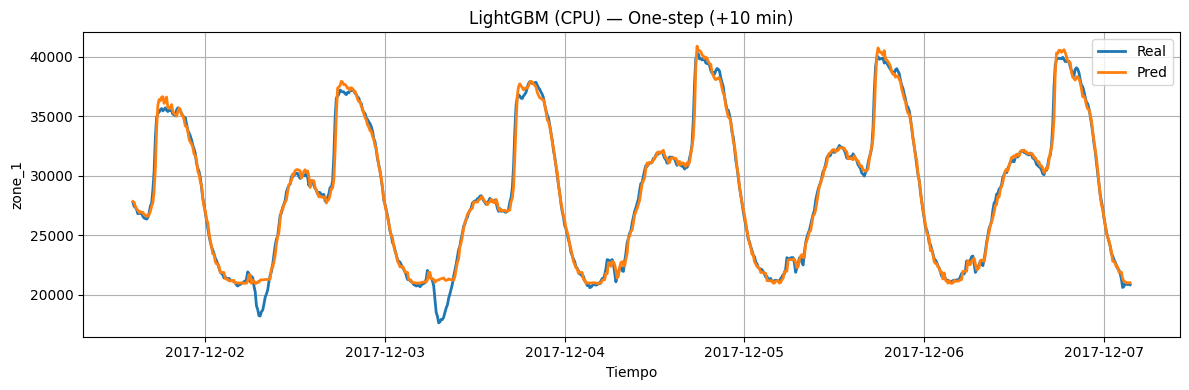

In [ ]:
# PRONÓSTICO A 1 PASO — One-step
# Predicciones normalizadas
y_pred_val = lgb_model.predict(Xva2, num_iteration=best_iter)
y_pred_te  = lgb_model.predict(Xte2, num_iteration=best_iter)

# Invertir escala
y_val_inv      = inverse_target(yva, scalers)
y_pred_val_inv = inverse_target(y_pred_val, scalers)
y_te_inv       = inverse_target(yte, scalers)
y_pred_te_inv  = inverse_target(y_pred_te, scalers)

# Índice temporal para tramo en TEST
start = HISTORY_WINDOW + SHIFT_ONE_STEP - 1
idx_seg = test_df.index[start : start + len(y_te_inv)]

# Gráfico (opcional)
plot_segment(idx_seg[:800], y_te_inv[:800], y_pred_te_inv[:800],
             title="LightGBM (CPU) — One-step (+10 min)", target_name=TARGET_COL)


en el caso de LightGBM, la gráfica de one‑step (+10 min) muestra un comportamiento sólido. Las curvas real y predicha prácticamente se superponen, capturando tanto los picos como los valles diarios con muy poco error, lo cual se refleja en sus métricas bajas de test (sMAPE 1.546% y WAPE 1.522%).

##### Pronóstico a Múltiples Pasos

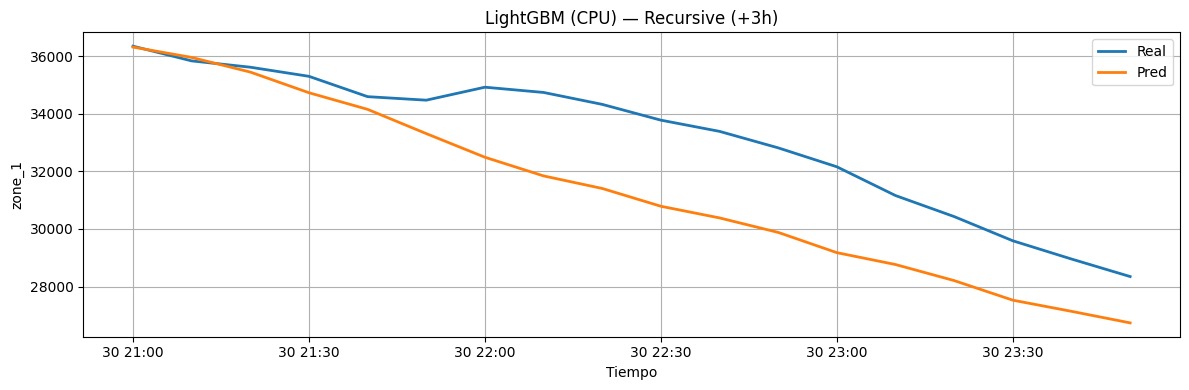

In [ ]:
# PRONÓSTICO A MÚLTIPLES PASOS — Recursive (3h)
STEPS = 18
feats_order = EXOG_COLS + [TARGET_COL]

# Semilla en test dejando espacio para 'STEPS' futuros
seed_start = max(0, len(test_n) - (HISTORY_WINDOW + STEPS))
seed_end   = seed_start + HISTORY_WINDOW
seed_win   = test_n[feats_order].values[seed_start:seed_end]  # normalizado, TARGET última col

# Usa tu función recursiva (sirve igual con LightGBM)
y_pred_rec_norm = recursive_forecast(lgb_model, seed_win, STEPS)
y_pred_rec      = inverse_target(y_pred_rec_norm, scalers)

# Verdaderos y tiempos
true_start = seed_end
true_end   = seed_end + STEPS
y_true_rec = test_df[TARGET_COL].values[true_start:true_end]
idx_future = test_df.index[true_start:true_end]

# Gráfico (opcional)
plot_segment(idx_future, y_true_rec, y_pred_rec,
             title="LightGBM (CPU) — Recursive (+3h)", target_name=TARGET_COL)


En el horizonte multi‑paso LightGBM mantiene la dirección de la tendencia decreciente del consumo, pero con un sesgo a la baja: la predicción cae más rápidamente que la serie real, generando una brecha cada vez mayor con el tiempo. Este desfase se refleja en el incremento de error (sMAPE 4.556% y WAPE 4.472%), lo que muestra que el modelo no logra estabilizar bien su proyección cuando se acumulan predicciones autoregresivas.

#### Modelo Boosting #3: CatBoost

##### Entrenamiento

In [ ]:
%pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.7 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostRegressor

# Tipos livianos
Xtr2 = Xtr2.astype("float32"); ytr = ytr.astype("float32")
Xva2 = Xva2.astype("float32"); yva = yva.astype("float32")
Xte2 = Xte2.astype("float32"); yte = yte.astype("float32")

cat_params = dict(
    iterations=100,
    depth=8,
    learning_rate=0.05,
    loss_function="RMSE",
    task_type='GPU',
    devices='0',
    verbose=50
)

cat_model = CatBoostRegressor(**cat_params)

In [ ]:
start = time.time()
cat_model.fit(Xtr2, ytr, eval_set=(Xva2, yva), use_best_model=True)
end = time.time()

cat_execution_time = end - start
best_iter = cat_model.get_best_iteration()

print(f"CatBoost (GPU) entrenado en {cat_execution_time:.2f} segundos.", f"(best_iteration={best_iter})" if best_iter is not None else "")

0:	learn: 0.9530316	test: 1.0125494	best: 1.0125494 (0)	total: 293ms	remaining: 29s
50:	learn: 0.1153896	test: 0.1804751	best: 0.1804751 (50)	total: 7.15s	remaining: 6.87s
99:	learn: 0.0569020	test: 0.1181883	best: 0.1181883 (99)	total: 14.9s	remaining: 0us
bestTest = 0.1181883179
bestIteration = 99
CatBoost (GPU) entrenado en 23.55 segundos. (best_iteration=99)


##### Evaluación

In [ ]:
# EVALUACIÓN — sMAPE / WAPE

# One-step
smape_val = smape(y_val_inv, y_pred_val_inv)
wape_val  = wape(y_val_inv, y_pred_val_inv)
smape_te  = smape(y_te_inv,  y_pred_te_inv)
wape_te   = wape(y_te_inv,   y_pred_te_inv)

print(f"[CATBOOST] ONE-STEP  → VAL  sMAPE: {smape_val:.3f}%")
print(f"[CATBOOST] ONE-STEP  → VAL WAPE: {wape_val:.3f}%")
print(f"[CATBOOST] ONE-STEP  → TEST sMAPE: {smape_te:.3f}%")
print(f"[CATBOOST] ONE-STEP  → TEST WAPE: {wape_te:.3f}%")

# Recursive (3h)
smape_rec = smape(y_true_rec, y_pred_rec)
wape_rec  = wape(y_true_rec, y_pred_rec)
print(f"[CATBOOST] RECURSIVE → TEST 3h sMAPE: {smape_rec:.3f}%")
print(f"[CATBOOST] RECURSIVE → TEST 3h WAPE: {wape_rec:.3f}%")


[CATBOOST] ONE-STEP  → VAL  sMAPE: 1.066%
[CATBOOST] ONE-STEP  → VAL WAPE: 1.005%
[CATBOOST] ONE-STEP  → TEST sMAPE: 1.222%
[CATBOOST] ONE-STEP  → TEST WAPE: 1.169%
[CATBOOST] RECURSIVE → TEST 3h sMAPE: 5.825%
[CATBOOST] RECURSIVE → TEST 3h WAPE: 5.486%


##### Pronóstico a 1 paso

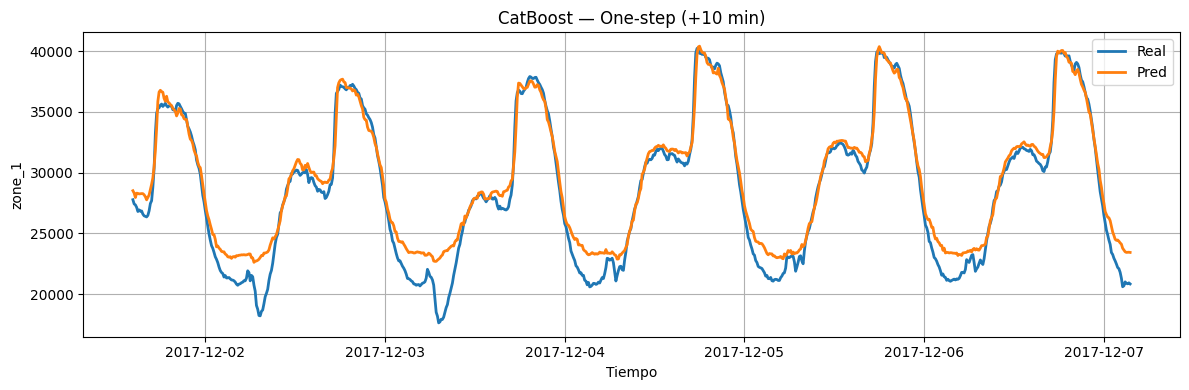

In [ ]:
# PRONÓSTICO A 1 PASO — One-step

# Predicciones (CatBoost usa best_iteration automáticamente con use_best_model=True)
y_pred_val = cat_model.predict(Xva2)
y_pred_te  = cat_model.predict(Xte2)

# Invertir a escala real
y_val_inv      = inverse_target(yva, scalers)
y_pred_val_inv = inverse_target(y_pred_val, scalers)
y_te_inv       = inverse_target(yte, scalers)
y_pred_te_inv  = inverse_target(y_pred_te, scalers)

# Índice temporal para graficar tramo en TEST
start = HISTORY_WINDOW + SHIFT_ONE_STEP - 1
idx_seg = test_df.index[start : start + len(y_te_inv)]

# Gráfico (opcional)
plot_segment(idx_seg[:800], y_te_inv[:800], y_pred_te_inv[:800],
             title="CatBoost — One-step (+10 min)", target_name=TARGET_COL)


La predicción de CatBoost sigue de manera bastante fiel la serie real, ajustándose bien a la forma general y respondiendo correctamente a la estacionalidad diaria. Sin embargo, se observa una ligera tendencia a sobreestimar los picos y a subestimar en los valles más profundos, lo que genera un pequeño sesgo. Aun así, la distancia entre real y predicción es mínima, lo que coincide con las métricas en este escenario (sMAPE 1.222% y WAPE 1.169%).

##### Pronóstico a Múltiples Pasos

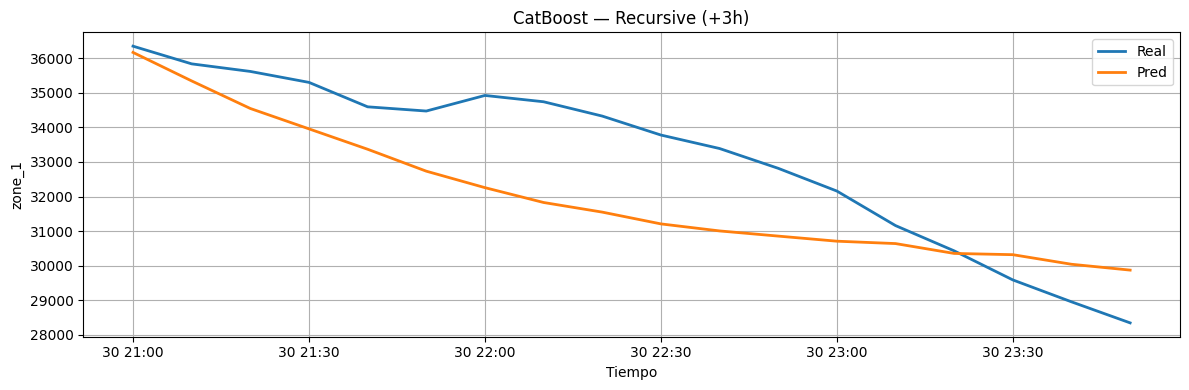

In [ ]:
# PRONÓSTICO A MÚLTIPLES PASOS — Recursive (3h)
STEPS = 18  # 3 horas = 18 * 10 min
feats_order = EXOG_COLS + [TARGET_COL]

# Semilla en test dejando espacio para 'STEPS' futuros
seed_start = max(0, len(test_n) - (HISTORY_WINDOW + STEPS))
seed_end   = seed_start + HISTORY_WINDOW
seed_win   = test_n[feats_order].values[seed_start:seed_end]  # normalizado, TARGET última col

# Predicción recursiva
y_pred_rec_norm = recursive_forecast(cat_model, seed_win, STEPS)
y_pred_rec      = inverse_target(y_pred_rec_norm, scalers)

# Verdadero y tiempos
true_start = seed_end
true_end   = seed_end + STEPS
y_true_rec = test_df[TARGET_COL].values[true_start:true_end]
idx_future = test_df.index[true_start:true_end]

# Gráfico
plot_segment(idx_future, y_true_rec, y_pred_rec,
             title="CatBoost — Recursive (+3h)", target_name=TARGET_COL)

Con multi-step se aprecia una divergencia progresiva. Aunque el modelo capta la dirección descendente, realiza una bajada más pronunciada que la serie real y mantiene un nivel más bajo durante todo el tramo. Esto genera un incremento notable en el error (sMAPE 5.825% y WAPE 5.486%), evidenciando que al apoyarse en sus propias predicciones recursivas se acumula un sesgo hacia la subestimación.

---

#### ANÁLISIS DE MÉTRICAS Y TIEMPO DE ENTRENAMIENTO:

El modelo Random Forest mostró el rendimiento más pobre en precisión (TEST one-step sMAPE 7.229% y WAPE 6.632%) y además requirió 42.67 segundos de entrenamiento, aunque en el pronóstico recursivo a 3 horas su error bajó marcando sMAPE 2.493% y WAPE 2.597%, lo cual indica un comportamiento inusual por la forma en que se construyeron las ventanas y podría reflejar limitaciones de la evaluación. XGBoost se entrenó rápido (8.40 segundos) y logró un buen equilibrio con métricas reducidas tanto en validación como en test (sMAPE ≈1.5%, WAPE ≈1.5% en one-step), aunque en el pronóstico recursivo su error se incrementa a 4.105% y 4.036%, mostrando que pierde estabilidad en horizontes largos, lo cual es esperado por acumulación de error. En contraste, LightGBM, con un tiempo de entrenamiento de 72.72 segundos, obtuvo métricas superiores a Random Forest pero más débiles que XGBoost y CatBoost en one-step (sMAPE 3.590%, WAPE 3.113%) y también perdió precisión en el horizonte recursivo (sMAPE 4.556%, WAPE 4.472%). Finalmente, CatBoost entrenado en 27.92 segundos con GPU fue el más preciso en one-step (sMAPE 1.222%, WAPE 1.169%), marcando el mejor ajuste inmediato, aunque en recursivo también pierde robustez (sMAPE 5.825% y WAPE 5.486%).

Para máxima precisión de predicciones inmediatas el mejor es CatBoost, y para un balance rápido entre costo y precisión, XGBoost es la mejor opción. En este caso destacan más los modelos de boosting que el de Random Forest.

#### Referencias:

Random Forest
- Breiman (2001), “Random Forests” (artículo original). ([stat.berkeley.edu](https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf))
- scikit-learn `RandomForestRegressor` (referencia de implementación). ([scikit-learn.org](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html))
- *The Elements of Statistical Learning* (cap. Random Forests). ([SpringerLink](https://link.springer.com/chapter/10.1007/978-0-387-84858-7_15))

XGBoost
- Chen & Guestrin (KDD 2016), “XGBoost: A Scalable Tree Boosting System” (paper base). ([kdd.org](https://www.kdd.org/kdd2016/papers/files/rfp0697-chenAemb.pdf))
- XGBoost docs — parámetros (regularización, subsample/colsample, etc.). ([xgboost.readthedocs.io](https://xgboost.readthedocs.io/en/stable/parameter.html))
- XGBoost docs — métodos de árbol (`hist`, `approx`, `exact`). ([xgboost.readthedocs.io](https://xgboost.readthedocs.io/en/stable/treemethod.html))

LightGBM
- Ke et al. (NeurIPS 2017), “LightGBM: A Highly Efficient GBDT” (paper original). ([proceedings.neurips.cc](https://proceedings.neurips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree.pdf))
- Documentación `lightgbm.LGBMRegressor` (API y parámetros). ([lightgbm.readthedocs.io](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html))
- Repositorio oficial (implementación y prácticas). ([GitHub](https://github.com/microsoft/LightGBM))

CatBoost:
- Dorogush, Ershov & Gulin, “CatBoost: unbiased boosting with categorical features” (paper). ([bioinf.jku.at](https://www.bioinf.jku.at/publications/older/2604.pdf))
- Documentación `CatBoostRegressor` (uso en regresión). ([Interactive Audio Lab](https://interactiveaudiolab.github.io/teaching/casa/HorchreiterSchmidhuber_LSTM.pdf))
- Guía de soporte GPU en CatBoost (configuración/uso). ([arXiv](https://arxiv.org/abs/1503.04069))

MLP (Perceptrón Multicapa):
- Rumelhart, Hinton & Williams (1986), *Backpropagation* (fundamento del entrenamiento). ([Stanford University](https://stanford.edu/~jlmcc/papers/PDP/Volume%201/Chap8_PDP86.pdf))